# Bayes-by-backprop
## Rotating MNIST

In [69]:
import jax
import optax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from chex import dataclass
from typing import Callable
from tqdm.notebook import tqdm
from flax.training.train_state import TrainState


from dynamax.utils import datasets
from dynamax.rebayes import bayes_by_backprop as bbb

In [71]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

## Load dataset

In [44]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

## Lossfn -- definition

In [37]:
import distrax
from functools import partial
from jaxtyping import Float, Array

In [29]:
@dataclass
class PriorParam:
    scale_obs: float
    scale_weight: float

def cost_fn(
    key: jax.random.PRNGKey,
    state: bbb.BBBParams,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    reconstruct_fn: Callable,
    model: nn.Module,
    priors: PriorParam
):
    """
    TODO:
    Add more general way to compute observation-model log-probability
    """
    scale_obs = priors.scale_obs
    scale_prior = priors.scale_weight
    
    # Sampled params
    params = bbb.sample_params(key, state, reconstruct_fn)
    params_flat = bbb.get_leaves(params)
    
    # Prior log probability (use initialised vals for mean?)
    logp_prior = distrax.Normal(loc=0.0, scale=scale_prior).log_prob(params_flat).sum()
    # Observation log-probability
    mu_obs = model.apply(params, X).ravel()
    logp_obs = distrax.Normal(loc=mu_obs, scale=scale_obs).log_prob(y).sum()
    # Variational log-probability
    logp_variational = jax.tree_map(
        lambda mean, logvar, x: distrax.Normal(loc=mean, scale=jnp.exp(logvar / 2)).log_prob(x),
        state.mean, state.logvar, params
    )
    logp_variational = bbb.get_leaves(logp_variational).sum()
    
    return logp_variational - logp_prior - logp_obs


def lossfn(key, params, X, y, model, reconstruct_fn, priors, num_samples=10):
    # TODO: add costfn as input
    keys = jax.random.split(key, num_samples)
    cost_vmap = jax.vmap(cost_fn, in_axes=(0, None, None, None, None, None, None))
    loss = cost_vmap(keys, params, X, y, reconstruct_fn, model, priors).mean()
    return loss


@partial(jax.vmap, in_axes=(0, None, None, None))
@partial(jax.jit, static_argnames=("reconstruct_fn",))
def sample_and_eval(key, state, X, reconstruct_fn):
    params_sample = bbb.sample_params(key, state, reconstruct_fn)
    return model.apply(params_sample, X)


@partial(jax.jit, static_argnames=("reconstruct_fn", "num_samples"))
def eval_mae(key, params, X, y, reconstruct_fn, num_samples=20):
    keys_sample = jax.random.split(key, num_samples)
    yhat_samples = sample_and_eval(keys_sample, params, X, reconstruct_fn).squeeze()
    yhat = yhat_samples.mean(axis=0)
    err_pp = y - yhat
    return jnp.abs(err_pp).mean(), yhat

## Model setup

In [31]:
class MLP(nn.Module):
    dim_out: int
    dim_hidden: int = 100
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        
        return x

In [33]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

In [73]:
batch = (100, 28 ** 2)
model = MLP(1, dim_hidden=200)
batch = jnp.ones(batch)

In [116]:
batch_size = 100
num_epochs = 2000
tx = optax.adam(1e-3)
keys_epochs = jax.random.split(key_train, num_epochs)

priors = PriorParam(scale_obs=5.0, scale_weight=0.5)
priors = PriorParam(scale_obs=2.0, scale_weight=0.5)
part_lossfn = partial(lossfn, priors=priors)

# Bayes-by-backprop params
b3p, (reconstruct_fn, num_params) = bbb.init_bbb_params(key_init, model, batch)

opt_state = TrainState.create(
    apply_fn=model.apply,
    params=b3p,
    tx=tx
)

In [124]:
%%time
losses = []
test_mae = []
for key_epoch in (pbar := tqdm(keys_epochs)):
    loss, opt_state = bbb.train_epoch(key, opt_state, X_train, y_train, batch_size, part_lossfn, model, reconstruct_fn)
    vmae, _ = eval_mae(key, opt_state.params, X_test, y_test, reconstruct_fn)
    pbar.set_description(f"{loss=:0.4e} | {vmae=:0.4f}")
    
    test_mae.append(vmae)
    losses.append(loss)
    
losses = np.array(losses)
test_mae = np.array(test_mae)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1min 8s, sys: 16.4 s, total: 1min 24s
Wall time: 1min 58s


## Model evaluation

In [125]:
mae, yhat_test = eval_mae(key, opt_state.params, X_test, y_test, reconstruct_fn)
mae

DeviceArray(14.314579, dtype=float32)

(0.0, 180.0)

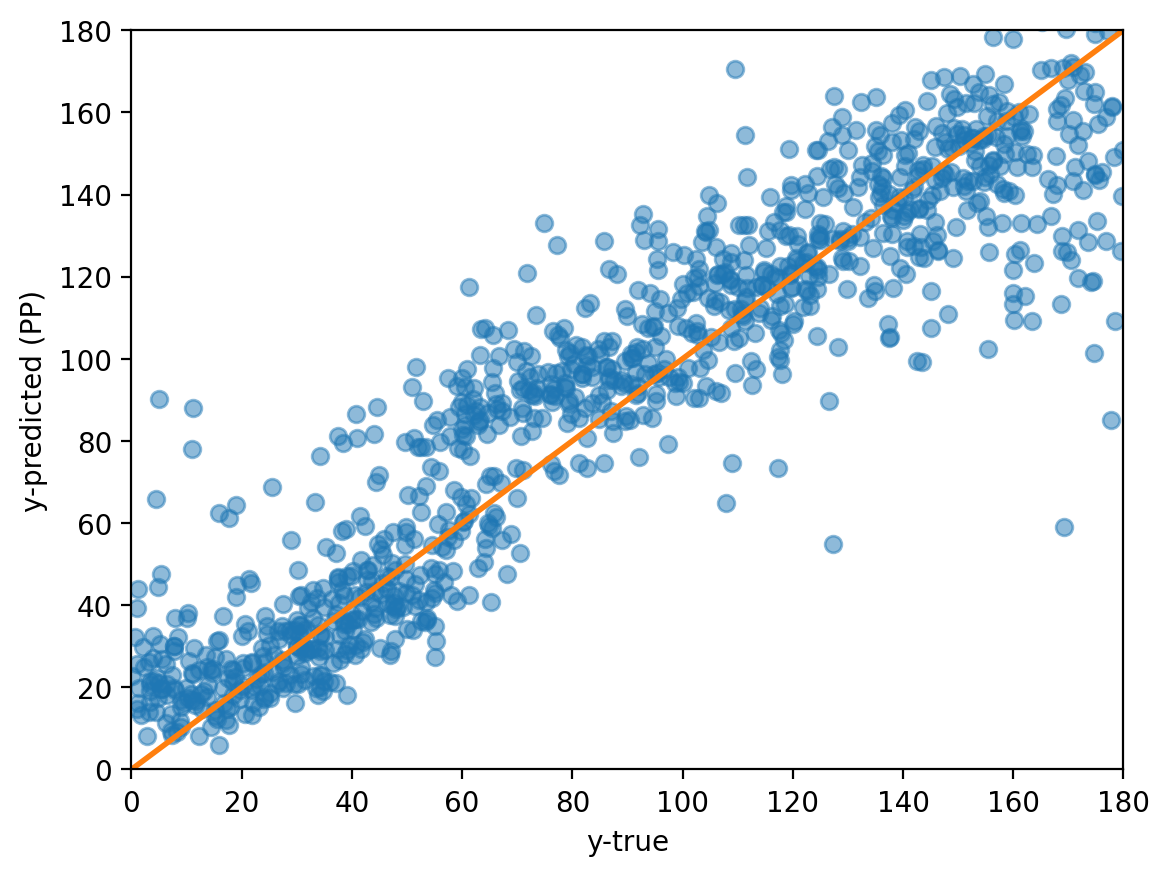

In [126]:
plt.scatter(y_test, yhat_test, alpha=0.5, edgecolors=None)
plt.ylabel("y-predicted (PP)")
plt.xlabel("y-true")
plt.plot([0, 180], [0, 180], c="tab:orange", linewidth=2)
plt.ylim(0, 180)
plt.xlim(0, 180)